# Multilevel Bayesian Correlations

intro and outline

## Outline
* [Pearson Correlation](#pearson-correlation)
* [Multilevel Correlation](#multilevel-correlation)
* [Robust Correlation](#robust-correlation)
* [Spearman Correlation](#spearman-correlation)
* [Use on real data](#real-data)



First let's load the packages we'll need, and set some settings.

In [1]:
# Packages
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sb
import pystan
from scipy.stats import pearsonr

# Plot settings
%matplotlib inline
sb.set()

# Settings for Stan
Niters = 1000
Nchains = 5

## Pearson Correlation
<a class="anchor" id="pearson-correlation"></a>

The Pearson correlation coefficient ($\rho$) is a measure of how correlated two variables are (e.g. $X_1$ and $X_2$), and is the ratio of the true covariance of the two variables to their expected covariance if they were perfectly correlated:

$$
\rho_{X_1,X_2} = \frac{\text{cov}(X_1,X_2)}{\sigma_{X_1} \sigma_{X_2}}
$$

where
* $\text{cov}(X_1, X_2)$ is the covariance between $X_1$ and $X_2$
* $\sigma_{X_1}$ is the standard deviation of $X_1$, and 
* $\sigma_{X_2}$ is the standard deviation of $X_2$

This coefficient ranges between 1 (when the two variables are perfectly positively correlated) and -1 (when they are perfectly negatively correlated), and a coefficient value of 0 means that there is no correlation.


Let's generate some data which we KNOW displays a positive correlation between two variables:

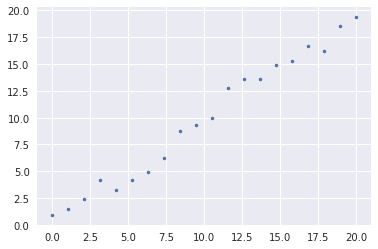

In [2]:
# Create some dummy data with known correlation
X = np.zeros((20,2))
X[:,0] = np.linspace(0, 20, 20)
X[:,1] = X[:,0] + np.random.randn(20)

# Plot dummy data
plt.plot(X[:,0], X[:,1], '.')
plt.show()

We can compute the maximum likelihood estimate of $\rho$ (that is, the correlation coefficient value which is most likely) by using the equation above.  The `scipy.stats` package also provides a function for computing $\rho$, along with a p-value which tells us the probability of getting that value for $\rho$ if there were no correlation at all. 

In [3]:
# Compute Pearson correlation coefficient
from scipy.stats import pearsonr
rho, pval = pearsonr(X[:,0], X[:,1])
print('Correlation coefficient: ', rho, '( p =', pval, ')')

Correlation coefficient:  0.9911232504719679 ( p = 3.1472150984129227e-17 )


But what if we want to know the probability of seeing *any* value of $\rho$?  If we could compute a probability distribution over the possible values $\rho$ could take, then we would be able to make inferences as to the value of $\rho$.  What I mean by "inferences" is statements such as "there's a 95% probability that the value of $\rho$ is between 0.3 and 0.6".  Using frequentist statistics (which gave us the p-value above), we can only make claims like "assuming there is no correlation, the probability of observing our data is such-and-such."  Having a full probability distribution over the values of $\rho$ would give us a more explicit way of expressing how uncertain we are about the value of $\rho$, and also would let us understand how likely different effect sizes are.

To get that probability distribution, we can perform a Bayesian correlation.  Basically what we'll be doing is "fitting" a bivariate (2D) normal distribution to our points, and then computing $\rho$ from that normal distribution. 

TODO: IMAGE OF FITTING A GAUSSIAN TO POINTS, W/ SIGMAS AND RHO

A univariate (1D) normal distribution is defined by its mean and variance.  But a bivariate normal distribution is defined by its mean *vector* $\mu$ (i.e. the mean in each dimension ) and its covariance matrix (the covariance between each pair of dimensions).  The covariance matrix for a bivariate Gaussian is just a 2x2 matrix, and people usually use the symbol $\Sigma$ to refer to it (not to be confused with the same symbol which is used for a sum!).  The diagonal elements of the matrix are just the variance of the data in each dimension, and the non-diagonal elements are the covariance between dimensions:

$$
\Sigma = 
\begin{bmatrix}
    \text{cov}(X_1,X_1) & \text{cov}(X_1,X_2) \\
    \text{cov}(X_1,X_2) & \text{cov}(X_2,X_2) 
\end{bmatrix}
$$

again where $\text{cov}(A, B)$ is the covariance between $A$ and $B$ (and the variance if $A$ and $B$ are the same).  Then the probability value of that distribution at any $x,y$ location can be computed:

$$
\mathcal{N}(x,\mu,\Sigma) = \frac{\text{exp}(-\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu))}{\sqrt{(2 \pi)^2 | \Sigma |}}
$$

When the covariance is more positive, the distribution is stretched out in a positive direction, and when it is more negative, the distribution is stretched in the negative direction:

In [ ]:
# TODO: CODE TO GENERATE and plot DIFFERENT 2D DISTS , W/ COV MATS BELOW, RHO = [-0.9 -0.5 0 0.5 0.9]

Notice that the Pearson correlation coefficient ($\rho$) also tells us how stretched out the normal distribution is - and in which direction!  This is because the Pearson correlation coefficient is defined by the covariance values (relative to the variances).  If we rearrange the equation for $\rho$,

$$
\text{cov}(X_1,X_2) = \rho_{X_1,X_2} \sigma_{X_1} \sigma_{X_2}
$$

then we can re-define the covariance matrix using only the variances ($\sigma_{X_1}$ and $\sigma_{X_2}$) and $\rho$:

$$
\Sigma = 
\begin{bmatrix}
   \sigma_{X_1} \sigma_{X_1} & \rho ~ \sigma_{X_1} \sigma_{X_2} \\
    \rho ~ \sigma_{X_1} \sigma_{X_2} & \sigma_{X_2} \sigma_{X_2} 
\end{bmatrix}
$$

(This also depends on the fact that the variance is equal to the square of the standard deviation, i.e. $\text{cov}(X_1,X_1) = \sigma_{X_1} \sigma_{X_1}$)

Now that we know how to compute $\rho$ from a normal distribution (and vice-versa), we can fit a normal distribution to our data in a Bayesian way.  I've been describing the problem as if we first fit a normal distribution, and then compute $\rho$ from that distribution.  However with Bayesian models, it's usually useful to think of things the other way around: *given* a certain value of $\rho$, we'll compute what the normal distribution should be, and then we'll compute the likelihood that our data came from that distribution.  That way we can test different values of $\rho$ and see how likely or unlikely they are to explain our data!

We're going to use [Stan](http://mc-stan.org/) for defining and fitting our Bayesian model.  Stan is a platform for Bayesian modelling, which lets you use a relatively simple programming language to define the model, and then fits that model to your data, returning the posterior probability distributions for your parameter(s) of interest.  The code for a Stan model consists of 3 main blocks (and we're going to also use 1 additional optional block).  

First is the "data" block, where we will define what data we're trying to fit.  

Second is the "parameters" block, where we will define what parameters our model uses.  In our case the model's parameters are $\rho$ (the Pearson correlation coefficient), $\mu$ (the vector of means in each dimension for the normal distribution), and $\sigma$ (the vector of standard deviations in each dimension).

The third (optional) block that we'll use is the "transformed parameters" block.  We'll use this block to compute the covariance matrix from $\rho$ and $\sigma$, as described above.

Finally, the last block is the "model" block.  Here we'll define how to compute the probability of the data given the parameters.  As described above, we're just modeling our datapoints as being drawn from a normal distribution (which is defined by $\rho$, $\mu$, and $\sigma$).  Stan provides a simple syntax for modeling datapoints as being drawn from a distribution: `data ~ distribution`.

Let's define the Stan code, compile the model, fit it to our data, and plot the resulting posterior distribution for $\rho$!  We'll also plot the distributions for $\mu$ and $\sigma$, just to make sure our model isn't doing anything crazy.

In [4]:
#STAN code string for a basic pearson correlation
PearsonCorrelation = """
data {
    int<lower=0> N; //number of datapoints
    vector[2] X[N]; //datapoints
}

parameters {
    vector[2] mu;               //mean
    vector<lower=0>[2] sig;     //std dev of each variable
    real<lower=-1,upper=1> rho; //Pearson's rho
}

transformed parameters {
    // Compute the covariance matrix from rho and sigmas
    cov_matrix[2] C;
    C[1,1] = sig[1] * sig[1];
    C[1,2] = rho * sig[1] * sig[2];
    C[2,1] = rho * sig[1] * sig[2];
    C[2,2] = sig[2] * sig[2];
}

model {
    // Model our data as being drawn from multivariate normal 
    // distribution with mean mu and covariance matrix C
    X ~ multi_normal(mu, C);
}
"""

In [5]:
# Compile the Stan model
model_pc = pystan.StanModel(model_code=PearsonCorrelation)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5fe00a7d88522e46825f0c82ee39fe6c NOW.


In [6]:
# Data for Stan
data = {'N' : X.shape[0], #number of datapoints
        'X' : X} #the data

# Fit the model
fit = model_pc.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [7]:
# Print the results of the fit
print(fit)

Inference for Stan model: anon_model_5fe00a7d88522e46825f0c82ee39fe6c.
5 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2500.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]    9.99    0.05   1.44   6.94   9.07   10.0  10.93  12.79    931    1.0
mu[1]    9.82    0.05   1.39    6.9   8.94   9.83   10.7  12.53    917    1.0
sig[0]   6.55    0.04   1.15   4.78   5.73   6.39   7.18    9.3    727   1.01
sig[1]   6.36    0.04   1.11   4.63   5.57    6.2   6.97   8.99    749   1.01
rho      0.99  2.1e-4 6.2e-3   0.97   0.99   0.99   0.99    1.0    853    1.0
C[0,0]   44.3    0.61   16.4   22.8  32.79  40.83  51.61  86.47    721   1.01
C[1,0]  42.49    0.58  15.73  21.76  31.47  39.18  49.43  83.36    726   1.01
C[0,1]  42.49    0.58  15.73  21.76  31.47  39.18  49.43  83.36    726   1.01
C[1,1]  41.67    0.56  15.27  21.43  31.02  38.46  48.56  80.76    748   1.01
lp__   -55.01    0.06   1.65 -59.

In [8]:
# Get the MCMC samples (draws from the posterior distribution)
samples = fit.extract()

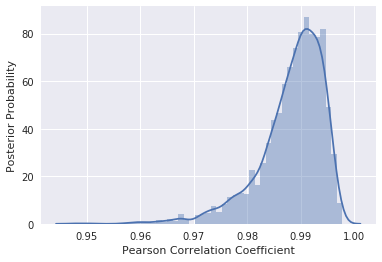

In [9]:
# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['rho'])
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

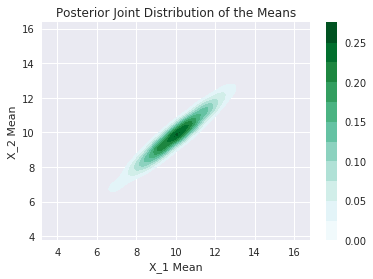

In [10]:
# Plot the posterior joint distribution for the means of the gaussian
plt.figure()
sb.kdeplot(samples['mu'][:,0], samples['mu'][:,1], 
           shade=True, shade_lowest=False, cbar=True)
plt.xlabel('X_1 Mean')
plt.ylabel('X_2 Mean')
plt.title('Posterior Joint Distribution of the Means')
plt.show()

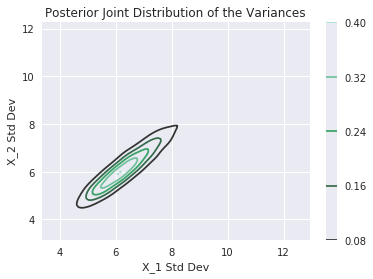

In [11]:
# Plot the posterior joint distribution for the standard deviations of the gaussian
plt.figure()
sb.kdeplot(samples['sig'][:,0], samples['sig'][:,1], 
           n_levels=5, cbar=True)
plt.xlabel('X_1 Std Dev')
plt.ylabel('X_2 Std Dev')
plt.title('Posterior Joint Distribution of the Variances')
plt.show()

The distribution for $\rho$ above showed that there's a very high probability of a correlation between our two variables!   If we had uncorrelated data, the posterior distribution for $\rho$ would be centered around 0, like this:

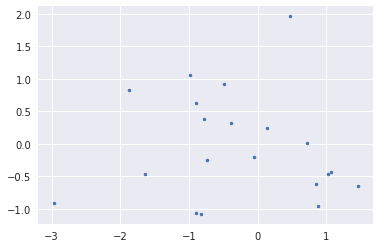

In [20]:
# Create some dummy data with no correlation
X = np.zeros((20,2))
X[:,0] = np.random.randn(20)
X[:,1] = np.random.randn(20)

# Plot dummy data
plt.plot(X[:,0], X[:,1], '.')
plt.show()

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


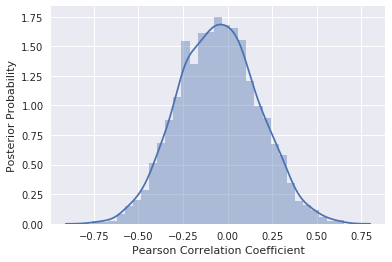

In [21]:
# Fit the Stan model
data = {'N' : X.shape[0], #number of datapoints
        'X' : X} #the data
fit = model_pc.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)
samples = fit.extract()

# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['rho'])
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

## Multilevel Correlation
<a class="anchor" id="multilevel-correlation"></a>

Sometimes, we want to compute the correlation between two variables, but have multiple measurements per group or individual.  In this case we want to see if there is a correlation between the variables we care about, but we also want to account for differences between groups.  If we don't account for those differences, sometimes we can get the wrong result, for example in certain cases of [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox).  

In a regression the way to handle this is to use a [multilevel model](https://en.wikipedia.org/wiki/Multilevel_model) (aka a "hierarchical model", also aka in this case a [random effect](https://en.wikipedia.org/wiki/Random_effects_model)), where each individual or group has their own coefficient.  But, these coefficients aren't completely independent - we model them as being drawn from a normal distribution (usually), so that different individuals or groups can have different coefficients, but the further their value is from the population mean, the less likely that parameter value is.  We can take a similar approach with correlations.  We'll allow the $\rho$ parameter to vary across individuals or groups, but not in a completely independent way.  

"Multilevel" models are called as such because there can literally be multiple levels to the model.  Normally, one has data points, and models those data points as being drawn from some distribution which has some parameters of interest.  This was the case in the above example of a Bayesian Pearson's correlation - we modeled the data as being drawn from a multivariate normal distribution with parameters $\mu$, $\sigma$, and $\rho$.  However, now we have a different $\rho$ parameter for each individual.  The data for that individual is drawn from the normal distribution defined by their parameters - that's the first "level".  

But now we also have a second level: each individual's parameter is drawn from a population distribution.  Each $\rho_i$ is drawn from a normal distribution with mean $\mu_{\rho}$ and standard deviation $\sigma_{\rho}$.  Now $\mu_{\rho}$ is the parameter we really care about: what is the likelihood that there is truly a correlation betwen our two variables - across the population!

TODO: IMAGE OF THE MULTILEVEL MODEL!

In theory we could even add a third level, for example nationality: we could have a separate population mean parameter for individuals from a certain country, and all the per-country mean parameters are drawn from another normal distribution.  For simplicity we're only going to work with two-level models here.

Let's generate some dummy data where we KNOW there is no correlation across the population, but because of individual differences, it might appear that there is a correlation when pooling data from all individuals together

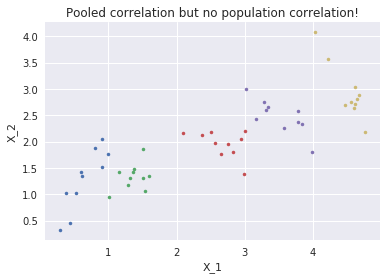

In [22]:
# Create and plot dummy data w/ pooled correlation but no population correlation
N = 10
Ns = 5
X = np.zeros((N*Ns,2))
I = np.zeros(N*Ns, dtype=int) #invididual/group number
plt.figure()
for iS in range(Ns):
    x = np.random.rand(N)
    X1 = x + iS
    X2 = x * (np.floor(Ns/2)-iS) + iS + 0.2*np.random.randn(N)
    X[iS*N:iS*N+N,0] = X1
    X[iS*N:iS*N+N,1] = X2
    I[iS*N:iS*N+N] = iS+1
    plt.plot(X1, X2, '.')
plt.title('Pooled correlation but no population correlation!')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.show()

Each color in the above plot represents samples from different individuals or groups.  Notice that if one pools the data from all individuals, there is a strong positive correlation between $X_1$ and $X_2$.  However, if we take each subject individually, two subjects show a positive correlation, two show a negative correlation, and one shows no correlation!

In [23]:
# Compute Frequentist estimates of the correlation
rho, pval = pearsonr(X[:,0], X[:,1])
print('Pooled correlation coefficient:', rho)
for iS in range(Ns):
    rho, pval = pearsonr(X[iS*N:iS*N+N,0], X[iS*N:iS*N+N,1])
    print('Individual', iS+1, '\'s correlation coefficient:', rho)

Pooled correlation coefficient: 0.8178709360772182
Individual 1 's correlation coefficient: 0.8873773881829878
Individual 2 's correlation coefficient: 0.3693373105143743
Individual 3 's correlation coefficient: -0.45357016095581665
Individual 4 's correlation coefficient: -0.7815679132530825
Individual 5 's correlation coefficient: -0.9193920507706945


And running a normal Bayesian correlation doesn't fix this problem:

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


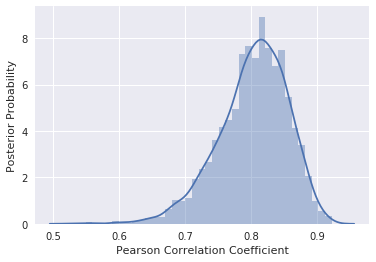

In [24]:
# Data for Stan
data = {'N' : X.shape[0], #number of datapoints
        'X' : X} #the data

# Fit the model
fit = model_pc.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)

# Get the MCMC samples (draws from the posterior distribution)
samples = fit.extract()

# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['rho'])
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

Now we'll define a Bayesian model in Stan which has two levels as described above.  In the first level, we'll model each datapoint as being drawn from the distribution corresponding to its individual (or group).  In the second level, we'll model each individual's $\rho$ parameter as being drawn from a population distribution.

(In a full model, one might want to also model per-subject $\mu$ parameters as being drawn from population distributions, but for the sake of simplicity we're going to skip that here)

In [25]:
#STAN code string for a two-level pearson correlation
MultilevelCorrelation = """
data {
    int<lower=0> N;    //number of datapoints
    int<lower=1> Ni;   //number of individuals/groups
    int<lower=1> I[N]; //individual of each datapoint
    vector[2] X[N];    //datapoints
}

parameters {
    vector[2] mu[Ni];               //per-individual mean
    vector<lower=0>[2] sig[Ni];     //per-individual std dev of each variable
    real<lower=-1,upper=1> rho[Ni]; //per-individual Pearson's rho
    real<lower=-1,upper=1> mu_rho;  //mean of population rhos
    real<lower=0> sig_rho;          //std dev of population rhos
}

transformed parameters {
    cov_matrix[2] C[Ni]; //covariance matrix for each individual
    for (i in 1:Ni) {
        C[i][1,1] = sig[i][1] * sig[i][1];
        C[i][1,2] = rho[i] * sig[i][1] * sig[i][2];
        C[i][2,1] = rho[i] * sig[i][1] * sig[i][2];
        C[i][2,2] = sig[i][2] * sig[i][2];
    }
}

model {
    // Each individual rho is drawn from population distribution
    rho ~ normal(mu_rho, sig_rho);
    
    // Each individual datapoint is drawn from its individual's distribution
    for (i in 1:N) {
        X[i] ~ multi_normal(mu[I[i]], C[I[i]]);
    }
}
"""

In [26]:
# Compile the Stan model for the multilevel correlation
model_ml = pystan.StanModel(model_code=MultilevelCorrelation)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68b8ba38946d7bba27d4fac57a895d29 NOW.


In [27]:
# Data for Stan
data = {'N' : X.shape[0], #number of datapoints
        'Ni': len(np.unique(I)), #number of individuals
        'I' : I, #subject of each datapoint
        'X' : X} #the datapoints

# Fit the model
fit = model_ml.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)

# Get the MCMC samples (draws from the posterior distribution)
samples = fit.extract()

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Now we can see how likely it is that there is a correlation between our two variables, when taking into account subject-specific differences:

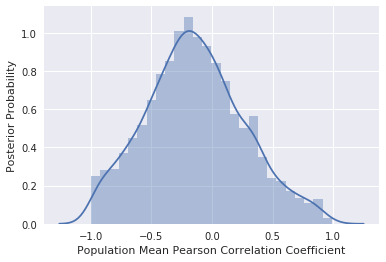

In [28]:
# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['mu_rho'])
plt.xlabel('Population Mean Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

As you can see, when accounting for individual differences, there's not much evidence for a correlation between our two variables.  If there were, we would expect to see a large majority of the posterior probability distribution to one side or the other of zero.  

The way the model "accounts for individual differences" is by allowing each individual to have a different parameter value.  In the two plots below, each color represents the posterior distribution for a different individual.

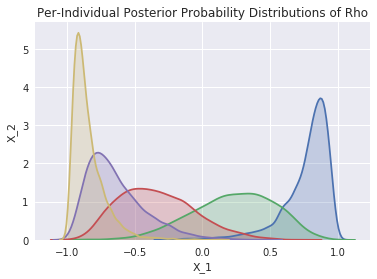

In [29]:
# Plot the per-subject posterior distributions for rho
plt.figure()
for iS in range(Ns):
    sb.kdeplot(samples['rho'][:,iS], shade=True)
plt.title('Per-Individual Posterior Probability Distributions of Rho')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.show()

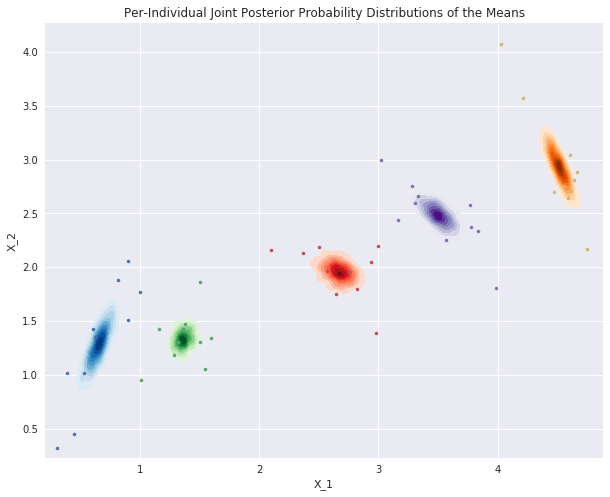

In [30]:
# Plot the posterior joint distribution for the means
plt.figure(figsize=(10, 8))
cmaps = ["Blues", "Greens", "Reds", "Purples", "Oranges"]
for iS in range(Ns):
    sb.kdeplot(samples['mu'][:,iS,0], samples['mu'][:,iS,1], 
               shade=True, shade_lowest=False, cmap=cmaps[iS])
    plt.plot(X[iS*N:iS*N+N,0], X[iS*N:iS*N+N,1], '.')
plt.title('Per-Individual Joint Posterior Probability Distributions of the Means')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.show()

What about when there IS a positive correlation at the population level, but it's not apparent if you pool the data together?  Let's create such a dataset.  We'll also decrease the number of observations per individual, so that we can see the advantages of working with multilevel models when you have very few datapoints per individual or group.

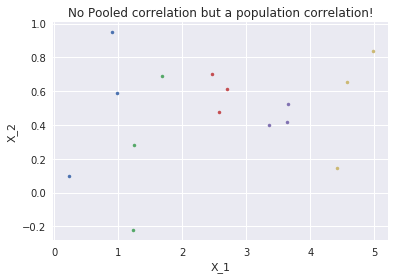

In [31]:
# Create and plot dummy data w/ no pooled correlation but a population correlation
N = 3
Ns = 5
X = np.zeros((N*Ns,2))
I = np.zeros(N*Ns, dtype=int) #invididual/group number
plt.figure()
for iS in range(Ns):
    x = np.random.rand(N)
    X1 = x + iS
    X2 = x + 0.2*np.random.randn(N) - 0.04*iS
    X[iS*N:iS*N+N,0] = X1
    X[iS*N:iS*N+N,1] = X2
    I[iS*N:iS*N+N] = iS+1
    plt.plot(X1, X2, '.')
plt.title('No Pooled correlation but a population correlation!')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.show()

Using frequentist statistics (without random effects, at least), we would see no correlation when pooling all the data together, but we also don't have enough data from each subject to be sure that the per-subject correlations are real (i.e., the power is too low - look at those awful p-values)!

In [32]:
# Compute Frequentist estimates of the correlation
rho, pval = pearsonr(X[:,0], X[:,1])
print('Pooled correlation coefficient:', rho, '(p=', pval, ')')
for iS in range(Ns):
    rho, pval = pearsonr(X[iS*N:iS*N+N,0], X[iS*N:iS*N+N,1])
    print('Individual', iS+1, '\'s correlation coefficient:', rho, '(p=', pval, ')')

Pooled correlation coefficient: 0.22866093909609267 (p= 0.4123781438705069 )
Individual 1 's correlation coefficient: 0.8624784607302567 (p= 0.3378220694541381 )
Individual 2 's correlation coefficient: 0.8514535304618551 (p= 0.351443143799212 )
Individual 3 's correlation coefficient: -0.3647160298505319 (p= 0.7623321361732706 )
Individual 4 's correlation coefficient: 0.635721394584585 (p= 0.5614054498656639 )
Individual 5 's correlation coefficient: 0.8666988822164186 (p= 0.33247483108804826 )


And again, using the non-multilevel Bayesian model doesn't fix this problem:

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


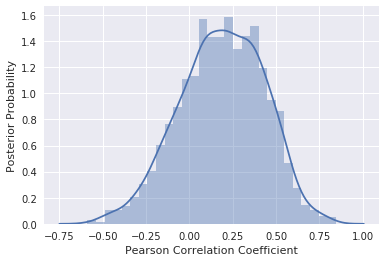

In [33]:
# Data for Stan
data = {'N' : X.shape[0], #number of datapoints
        'X' : X} #the data

# Fit the non-multilevel model
fit = model_pc.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)

# Get the MCMC samples (draws from the posterior distribution)
samples = fit.extract()

# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['rho'])
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

However, the multilevel model is able to correctly infer that there is a high probability of there being a positive correlation at the population level!

In [34]:
# Data for Stan
data = {'N' : X.shape[0], #number of datapoints
        'Ni': len(np.unique(I)), #number of individuals
        'I' : I, #subject of each datapoint
        'X' : X} #the datapoints

# Fit the multilevel model
fit = model_ml.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)

# Get the MCMC samples (draws from the posterior distribution)
samples = fit.extract()

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


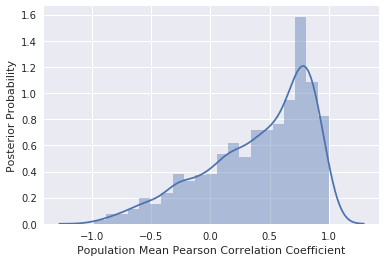

In [35]:
# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['mu_rho'])
plt.xlabel('Population Mean Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

An additional advantage of the multilevel model is that information from the population is used to inform individuals' parameter estimates (instead of only vice-versa).  This means that even when we have a very low number of datapoints per individual, the multilevel model can have a more certain estimate of an individual's parameter values than would be obtained by fitting a model using only the data from a single individual.  (Of course, this certainty depends on the model's assumptions being true...)  Also note that this feature isn't specific to *Bayesian* multilevel models - this is just a benefit of using a mixed model where individual/group parameters are allowed to vary in a constrained way.  Notice how precise the multilevel model's per-subject estimates are:

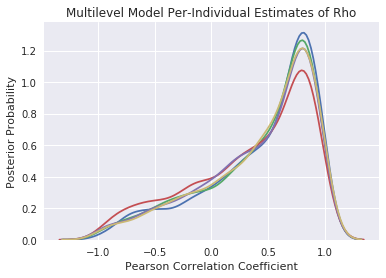

In [36]:
# Plot the per-subject posterior distributions for rho
plt.figure()
for iS in range(Ns):
    sb.kdeplot(samples['rho'][:,iS])
plt.title('Per-Individual Posterior Probability Distributions of Rho')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.title('Multilevel Model Per-Individual Estimates of Rho')
plt.show()

Whereas if we were to fit a non-multilevel model to each subject individually, our uncertainty would be much higher:

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


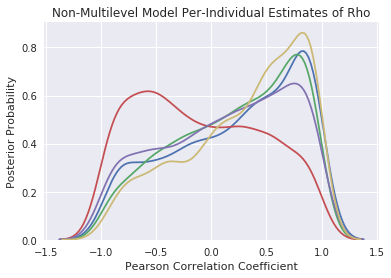

In [37]:
# Fit the non-multilevel model for each individual, individually
plt.figure()
for iS in range(Ns):
    tX = X[iS*N:iS*N+N,:] #data for this subject
    data = {'N' : tX.shape[0],
            'X' : tX}
    fit = model_pc.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)
    samples = fit.extract()
    sb.kdeplot(samples['rho'])
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.title('Non-Multilevel Model Per-Individual Estimates of Rho')
plt.show()

Of course you might ask: isn't that cheating?  How is it fair to use information about *other* members of a population when trying to determine information about an individual?  Isn't that... Rho-cism?  Well, no.  Racism (and sexism, and many other stereotypes and prejudices) depend on perceived population distributions which are, to use the statistical term, *bullshit* (i.e., inaccurate).  What if we're interested in obtaining *accurate* population and individual estimates?

From a Bayesian perspective, using the population distribution to inform your estimate of an individual is exactly the right thing to do.  Suppose the only information you have about me is a photo taken from 2 miles away (in addition to the fact that I'm a human...), and you want to determine my height.  I only occupy 1 pixel of the photograph, so your uncertainty as to my height is extremely high.  However, knowing that I'm a member of a given population (i.e. the population of all humans), makes you *pretty sure* I'm between 4 and 8 feet tall, because you know the distribution of heights for other members of that population.  I'd have to be pretty large in that photograph to convince you that I was any larger than, say, 10 feet tall.  But if you had 100 photographs all where I looked 11 feet tall, then you'd have to give more weight to that data than to what you knew about the population distribution.  And if you start seeing lots of photographs of lots of other 11-foot-tall people, you might want to update what you consider the population distribution.

In a multilevel model, we allow the population distribution to act as a [prior](https://en.wikipedia.org/wiki/Prior_probability) on our estimate of the parameters for each individual.  If we don't have any information about an individual, the multilevel model just assumes that individual's parameters are more likely to be close to the population mean (or more accurately, to follow the population distribution).  But given more and more data from a specific individual, that individual's estimate is pulled away from the population distribution towards the value that the observations indicate. 

The key here is that we're estimating each individual's parameters using the population distribution as a prior, while *at the same time* estimating the population distribution from the individuals' parameters!

[![AT THE SAME TIME!!!](https://media1.tenor.com/images/b2190afe666915580adb0890260362d1/tenor.gif?itemid=4895431)](https://tenor.com/view/mind-blown-bill-nye-science-guy-explosions-incredible-gif-4895431)

Next, we'll see how we can tweak our correlation to deal with outliers (via robust correlations) and/or nonlinear relationships (via the Spearman's rank correlation).

## Robust Correlation
<a class="anchor" id="robust-correlation"></a>

One problem with using normal distributions in a model is that they don't handle outliers very well.  That is, they assign more weight to observations which lie far away from the mean than maybe they should.  For example, suppose we gather test scores from 20 children, and around 68% of the scores are between 80 and 100, but Jimmy's score is 20.  A normal distribution centered at 90 with a standard deviation of 10 would put the odds of getting Jimmy's score at around one in a 309 billion.  But that's *really* unlikely.  Like, *ludicrously* unlikely.  That would imply that Jimmy is literally the dumbest human on Earth.  That's probably not the case.  Jimmy was probably just zoning out.  The effect of this is that when we use normal distributions to model data, outliers have a huge effect on our estimates.

The reason normal distributions assign so much weight to outliers is because they're a so-called "light-tailed distribution", meaning that the "tails" or edges of the distribution have a very low percentage of the probability mass, while the vast majority of the probability mass is centered close to the mean.  What we can use instead is a "heavy-tailed" distribution, whose tails aren't as ludicrously unlikely, but are still less likely than values at the center.  A commonly used heavy-tailed distribution is the [t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).  As you can see below, this distribution doesn't assign as ludicrously low probabilities to outliers - but outliers still have a lower probability than observations around the mean.




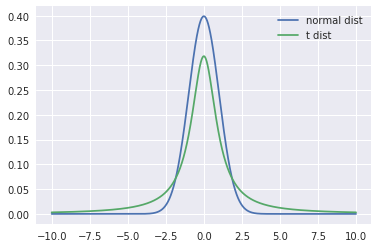

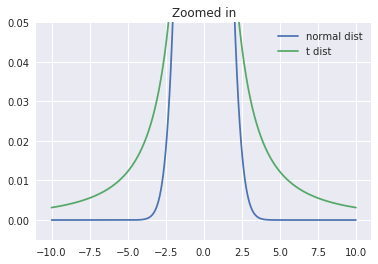

In [38]:
# Plot normal distribution vs t-distribution
from scipy.stats import norm, t
x = np.arange(-10, 10, 0.001)
p_normal = norm.pdf(x,0,1)
p_tdist = t.pdf(x,1,0,1)

plt.figure()
nd = plt.plot(x, p_normal, label='normal dist')
td = plt.plot(x, p_tdist, label='t dist')
plt.legend()
plt.show()

plt.figure()
nd = plt.plot(x, p_normal, label='normal dist')
td = plt.plot(x, p_tdist, label='t dist')
plt.ylim((-0.005, 0.05))
plt.title('Zoomed in')
plt.legend()
plt.show()

We can replace the normal distributions in our Bayesian model with t-distributions to ensure that outliers don't have such a huge effect on our estimates.  First, we'll replace the multivariate gaussian with a multivariate t-distribution.  That way, if an individual has datapoints which are outliers, it won't effect our estimate of that individual's parameter as much.

In the second level of our Bayesian model, we can also replace the population normal distribution with a t-distribution.  That way, if any of the *individuals* are an outlier, our estimate of the population distribution won't be overly skewed by that single individual.  For example, if all individuals show a small positive correlation, but one individual shows a strong negative correlation, using a t-distribution will allow our model to let that individual's $\rho$ be negative, while still maintaining a positive estimate of $\rho$ across the population.

Let's create a multilevel Bayesian correlation model in Stan which uses t-distributions instead of normal distributions.  This will allow for estimates which are more robust (to outliers).  The only changes we'll make is to change `normal(...)` to `multi_student_t(1,...)`.

(Note that the degrees of freedom of the t distributions could also be free parameters, but we'll just use DOF=1 here for simplicity)

In [ ]:
#STAN code string for a robust two-level Pearson correlation
RobustCorrelation = """
data {
    int<lower=0> N;    //number of datapoints
    int<lower=1> Ni;   //number of individuals/groups
    int<lower=1> I[N]; //individual of each datapoint
    vector[2] X[N];    //datapoints
}

parameters {
    vector[2] mu[Ni];               //per-individual mean
    vector<lower=0>[2] sig[Ni];     //per-individual std dev of each variable
    real<lower=-1,upper=1> rho[Ni]; //per-individual Pearson's rho
    real<lower=-1,upper=1> mu_rho;  //mean of population rhos
    real<lower=0> sig_rho;          //std dev of population rhos
}

transformed parameters {
    cov_matrix[2] C[Ni]; //covariance matrix for each individual
    for (i in 1:Ni) {
        C[i][1,1] = sig[i][1] * sig[i][1];
        C[i][1,2] = rho[i] * sig[i][1] * sig[i][2];
        C[i][2,1] = rho[i] * sig[i][1] * sig[i][2];
        C[i][2,2] = sig[i][2] * sig[i][2];
    }
}

model {
    // Each individual rho is drawn from population distribution
    rho ~ multi_student_t(1, mu_rho, sig_rho);

    // Each individual datapoint is drawn from its individual's distribution
    for (i in 1:N) {
        X[i] ~ multi_student_t(1, mu[I[i]], C[I[i]]);
    }
}
"""

In [ ]:
# data where some subjects have outlier datapoints
# fit stan
# show estimates and per-subject estimates

In [ ]:
# data where one subject is an outlier
# fit stan
# show estimates and per-subject estimates
# talk about how it allows that one subj to have outlier value, 
#   without effecting pop estimate as much (compare to fit w/ the old gaussian model)

## Spearman Correlation
<a class="anchor" id="spearman-correlation"></a>

In [ ]:
# TODO: just rank em and use already-compiled routines above for spearman's correlation

## Real Data
<a class="anchor" id="real-data"></a>

In [ ]:
# link a dataset and use on real data